In [1]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [2]:
# !pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install bertviz

In [3]:
!pip install umap-learn
!pip install --upgrade  py7zr rouge_score sacrebleu --no-cache-dir
!pip install -U transformers

In [4]:
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset

In [5]:
emotions=load_dataset("emotion")
emotions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
# emotions.set_format(type="pandas")

In [7]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [8]:
df=pd.DataFrame({
    'text':emotions['train']['text'],
    'label':emotions['train']['label']
})

In [9]:
classes=emotions['train'].features['label'].names

In [10]:
df['label name']=df['label'].apply(lambda x: classes[x])

In [11]:
df.sample(5)

,text,label,label name
12695,i feel like i need to keep pinching myself to ...,1,joy
15694,i know is that i feel fantastic,1,joy
14756,ive been feeling ignored,0,sadness
674,i ended up shoeless making me feel even more v...,4,fear
8814,i feel bashful discussing it i m a closet game...,4,fear


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

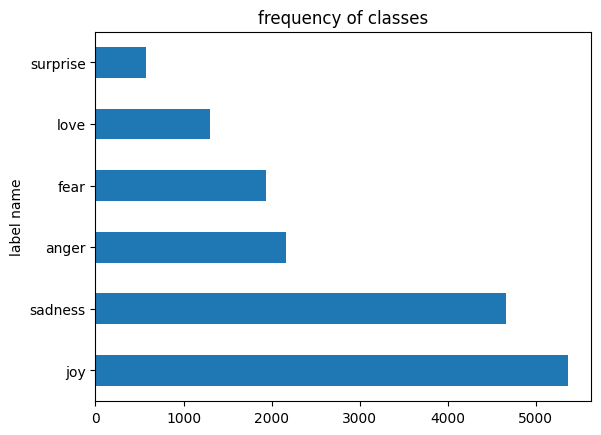

In [13]:
df['label name'].value_counts().plot(kind='barh')
plt.title("frequency of classes")
plt.show()

In [14]:
df['word_len']=df['text'].str.split().apply(len)

In [15]:
df.head()

,text,label,label name,word_len
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


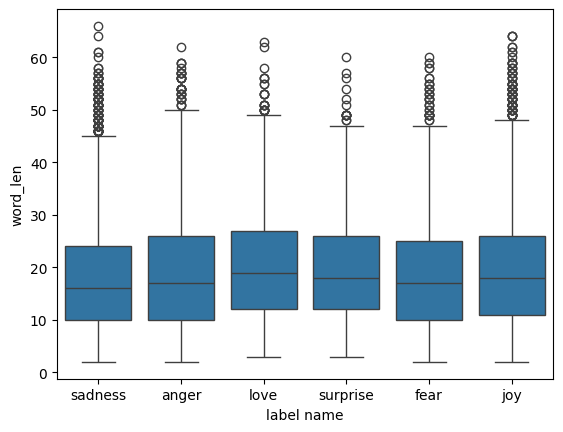

In [16]:
sns.boxplot(x=df['label name'], y=df['word_len'])
plt.show()

In [17]:
from transformers import AutoTokenizer,AutoModel
model_ckpt="distilbert-base-uncased"
tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

In [18]:
text="I love to code and build AI tools"

In [19]:
encoded_input=tokenizer(text,return_tensors='pt')
print(encoded_input)

{'input_ids': tensor([[ 101, 1045, 2293, 2000, 3642, 1998, 3857, 9932, 5906,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


In [20]:
tokenizer.vocab_size,tokenizer.model_max_length

(30522, 512)

In [21]:
emotions['train'][:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

In [22]:
def tokenize(batch):
  return tokenizer(batch['text'],padding=True,max_length=512,truncation=True)

In [23]:
emotions_encoded=emotions.map(tokenize,batched=True)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [24]:
emotions_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [25]:
from transformers import AutoModel
model=AutoModel.from_pretrained(model_ckpt)

In [26]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): DistilBertSdpaAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): L

In [27]:
with torch.no_grad():
  output=model(**encoded_input)
last_hidden_state=output.last_hidden_state

In [28]:
last_hidden_state.shape

torch.Size([1, 10, 768])

In [29]:
from transformers import AutoModelForSequenceClassification
num_classes=len(classes)
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=AutoModelForSequenceClassification.from_pretrained(model_ckpt,num_labels=num_classes).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [30]:
device

device(type='cuda')

In [31]:
#assigning training Arguments
batch_size=64
model_name="distilbert-finetuned-model_2"

In [32]:
from transformers import TrainingArguments
training_args=TrainingArguments(
    output_dir=model_name,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [33]:
from sklearn.metrics import accuracy_score,f1_score
def compute_metric(preds):
  labels=preds.label_ids
  preds=preds.predictions.argmax(-1)
  f1=f1_score(labels,preds,average='weighted')
  acc=accuracy_score(labels,preds)
  return {'accuracy':acc,'f1':f1}


In [34]:
from transformers import Trainer
trainer=Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metric,
    train_dataset=emotions_encoded['train'],
    eval_dataset=emotions_encoded['validation'],
    tokenizer=tokenizer
)

/tmp/ipython-input-34-3298574510.py:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


In [35]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.308898,0.912000,0.912005
2,0.539000,0.207736,0.930500,0.930542


TrainOutput(global_step=500, training_loss=0.5390189819335938, metrics={'train_runtime': 234.1877, 'train_samples_per_second': 136.643, 'train_steps_per_second': 2.135, 'total_flos': 718554424246272.0, 'train_loss': 0.5390189819335938, 'epoch': 2.0})

In [38]:
preds_output=trainer.predict(emotions_encoded['test'])
preds_output

PredictionOutput(predictions=array([[ 4.424175  , -0.61984444, -1.5947608 , -0.5084301 , -1.1718602 ,
        -1.5453156 ],
       [ 4.544457  , -0.9685128 , -1.461952  , -0.55518186, -0.8995177 ,
        -1.4925807 ],
       [ 4.5301113 , -1.0124525 , -1.3494186 , -0.8868182 , -0.74015653,
        -1.4175564 ],
       ...,
       [-1.0891492 ,  4.554155  , -0.5039361 , -1.420176  , -1.7516876 ,
        -0.8843267 ],
       [-1.1113547 ,  4.5684843 , -0.49049187, -1.47093   , -1.6189301 ,
        -0.9406521 ],
       [-1.1444461 , -1.1994615 , -1.2230839 , -1.1765343 ,  2.4456697 ,
         2.2769594 ]], dtype=float32), label_ids=array([0, 0, 0, ..., 1, 1, 4]), metrics={'test_loss': 0.21538031101226807, 'test_accuracy': 0.9195, 'test_f1': 0.9184472676297672, 'test_runtime': 3.963, 'test_samples_per_second': 504.667, 'test_steps_per_second': 8.075})

In [39]:
preds_output.metrics

{'test_loss': 0.21538031101226807,
 'test_accuracy': 0.9195,
 'test_f1': 0.9184472676297672,
 'test_runtime': 3.963,
 'test_samples_per_second': 504.667,
 'test_steps_per_second': 8.075}

In [41]:
y_pred=np.argmax(preds_output.predictions,axis=1)
y_pred

array([0, 0, 0, ..., 1, 1, 4])

In [46]:
y_true=emotions['test']['label']
y_true=np.array(y_true)
y_true

array([0, 0, 0, ..., 1, 1, 4])

In [48]:
from sklearn.metrics import classification_report

In [51]:
print(classes)
print(classification_report(y_true,y_pred))

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       581
           1       0.94      0.94      0.94       695
           2       0.79      0.82      0.80       159
           3       0.92      0.92      0.92       275
           4       0.88      0.91      0.89       224
           5       0.84      0.58      0.68        66

    accuracy                           0.92      2000
   macro avg       0.89      0.86      0.87      2000
weighted avg       0.92      0.92      0.92      2000



In [52]:
df['label name'].value_counts()


,count
label name,
joy,5362
sadness,4666
anger,2159
fear,1937
love,1304
surprise,572
